Importing the libraries for pre-processing the text

In [0]:
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
lemma=WordNetLemmatizer()
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

loading and reading the dataset

In [0]:
url = "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
df = pd.read_csv(url, sep='\t')

In [0]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


method for pre-processing the text

In [0]:
def clean_text(each_col):
    documents=[]
    for i in range(0,len(each_col)):
        document=str(each_col[i])
        document=re.sub('[^a-zA-Z]',' ',document)
        document=[lemma.lemmatize(w) for w in word_tokenize(str(document).lower())]
        document=' '.join(document)
        documents.append(document)
    return documents

Created another column for adding the pre-processed text

In [0]:
df['pre_processed']=clean_text(df.Phrase.values)

In [0]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,pre_processed
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

Analyzing the distribution of classes and that the dataset is imbalanced

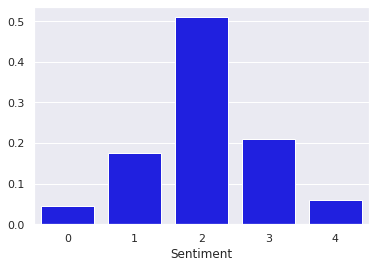

In [0]:
dist = df.groupby(["Sentiment"]).size()
dist = dist / dist.sum()
fig, ax = plt.subplots()
tips = sns.load_dataset("tips")
sns.barplot(dist.keys(), dist.values, color = "blue");


Initializing the X (pre-processed text) and Y (Sentiment as the target variable) 

In [0]:
from keras.utils import to_categorical
X = df['pre_processed']
Y = (df['Sentiment'].values)
print(Y)

Using TensorFlow backend.


[1 2 2 ... 3 2 2]


Splitting the dataset in the ratio 0f 70:30 with random state of 2003

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2003)

Converting the Y_test into one-hot label 

In [0]:
Y_test = to_categorical(Y_test)
print(Y_test)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [0]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(109242,) (109242,)
(46818,) (46818, 5)


using the X_train and Y_train for resampling the training dataset

In [0]:
x_train = X_train.tolist() 
l = []
for i in range(len(x_train)):
        join = (x_train[i],Y_train[i])
        l.append(join)
D = pd.DataFrame(l,columns=['pre_processed', 'Sentiment'])

In [0]:
D.head()

,pre_processed,Sentiment
0,their age,2
1,gorgeous epic,4
2,fan of the gross out comedy,2
3,the filmmaker ascends literally to the olympus...,4
4,twisting mystery,2


Assigning the texts of each classes into each objects and then resampling the training dataset

In [0]:
from sklearn.utils import resample
category_0 = D[D['Sentiment']==0]
category_1 = D[D['Sentiment']==1]
category_2 = D[D['Sentiment']==2]
category_3 = D[D['Sentiment']==3]
category_4 = D[D['Sentiment']==4]

category_0_sample = resample(category_0,replace=True,n_samples=75000,random_state=2003)
category_1_sample = resample(category_1,replace=True,n_samples=75000,random_state=2003)
category_2_sample = resample(category_2,replace=True,n_samples=75000,random_state=2003)
category_3_sample = resample(category_3,replace=True,n_samples=75000,random_state=2003)
category_4_sample = resample(category_4,replace=True,n_samples=75000,random_state=2003)
df_resampled = pd.concat([category_0_sample, category_1_sample,category_2_sample,category_3_sample,category_4_sample])

Assigning the new resampled texts and its corresponding classes to X_train and Y_train respectively

In [0]:
X_train = df_resampled['pre_processed']
Y_train= to_categorical(df_resampled['Sentiment'].values)

In [0]:
print(X_train.shape)

(375000,)


In [0]:
print(Y_train.shape)

(375000, 5)


Importing libraries for padding and sequencing the text

In [0]:
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Finding the maximum number of unique words

In [0]:
words=' '.join(X_train)
words=word_tokenize(words)
dist=FreqDist(words)
num_word=len(dist)

Finding the maximum length of words for each document

In [0]:
doc_len=[]
for text in X_train:
    word=word_tokenize(text)
    l=len(word)
    doc_len.append(l)    
max_doc_len=np.max(doc_len)
max_doc_len

48

Initializing the number of epochs, batch size, maximum features and maximum words

In [0]:
max_features = num_word
max_words = max_doc_len
batch_size = 256
epochs = 40
num_classes=5

tokenizing the text with keras tokenizer

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Initializing the padded sequence words in X_train and X_test

In [0]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Importing the libraries for creating the model

In [0]:
from keras.layers import Dense,Dropout,Embedding,Conv1D,Flatten,MaxPooling1D,SpatialDropout1D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adamax

In [0]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import LeakyReLU, PReLU
from keras.layers import Dropout

Creating the model with embedding layer, dropout layer for reducing overfitting, convolutional layer, activation layer and max_pooling layer

In [0]:
model = Sequential()
# Input / Embdedding
model.add(Embedding(max_features, 100, input_length=max_words))
# CNN
model.add(SpatialDropout1D(0.5))
model.add(Conv1D(32, kernel_size=3, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, padding='same'))
model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, padding='same'))
model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(5, activation='softmax'))

Importing metrics for calculating precision and recall

In [0]:
!pip install keras-metrics
import keras_metrics

Compiling and fitting the layer

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [0]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 375000 samples, validate on 46818 samples
Epoch 1/40
375000/375000 [==============================] - 12s 32us/step - loss: 1.0483 - acc: 0.5552 - precision: 0.7535 - recall: 0.5759 - val_loss: 0.9653 - val_acc: 0.5919 - val_precision: 0.4519 - val_recall: 0.4909
Epoch 2/40
375000/375000 [==============================] - 12s 32us/step - loss: 0.7818 - acc: 0.6777 - precision: 0.7894 - recall: 0.7935 - val_loss: 0.9661 - val_acc: 0.5902 - val_precision: 0.3879 - val_recall: 0.6160
Epoch 3/40
375000/375000 [==============================] - 12s 31us/step - loss: 0.6910 - acc: 0.7197 - precision: 0.8144 - recall: 0.8532 - val_loss: 0.9755 - val_acc: 0.5956 - val_precision: 0.4095 - val_recall: 0.5751
Epoch 4/40
375000/375000 [==============================] - 12s 31us/step - loss: 0.6292 - acc: 0.7481 - precision: 0.8313 - recall: 0.8824 - val_loss: 0.9923 - val_acc: 0.6018 - val_precision: 0.3766 - val_recall: 0.6406
Epoch 5/40
375000/375000 [==============================] - 1

Saving and loading the model

In [0]:
model.save('1110186_1dconv_reg.h5')

In [0]:
from keras.models import load_model
model = load_model('1110186_1dconv_reg.h5',{'binary_precision':keras_metrics.binary_precision(), 'binary_recall':keras_metrics.binary_recall()})

Evaluating the model

In [0]:
val_loss, val_acc, val_prec, val_recall  = model.evaluate(X_test, Y_test, batch_size=256)

46818/46818 [==============================] - 1s 13us/step


Calculating accuracy, precision and recall

In [0]:
print(' accuracy', val_acc)

 accuracy 0.6053227392421986


In [0]:
print(' val_prec', val_prec)

 val_prec 0.39223813110805433


In [0]:
print(' val_recall', val_recall)

 val_recall 0.48396094837359555


Calculating the F1 score

In [0]:
f1_score = 2 * ((val_prec*val_recall)/(val_prec+val_recall))
print(' f1_score', f1_score)

 f1_score 0.43329864722442046


In [0]:
print(' val_loss', val_loss)

 val_loss 1.6099175378388049
